In [154]:
# The following line makes sure that when we plot stuff it shows up in the notebook
%matplotlib inline 

import csv

import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

import itertools

from sklearn import svm
from sklearn import decomposition
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from pydub import AudioSegment

import textgrid

import os

In [192]:
classes = ["laughter", "garbage", "filler"]

num_classes = len(classes)
seg_length = 500
batch_size = 32
nb_epoch = 10

In [167]:
np.random.seed(5)

In [181]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold:
        trim_ms += chunk_size

    return trim_ms

def preprocess_signal(file):
    sig = AudioSegment.from_file(file, format="wav")

    start_trim = detect_leading_silence(sig)
    end_trim = detect_leading_silence(sig.reverse())

    duration = len(sig)    
    trimmed_sig = sig[start_trim:duration-end_trim]

    
    if(len(trimmed_sig) > 500) :
        samples = trimmed_sig[:500].get_array_of_samples()
        samples = np.array(samples)
        return mfcc(samples, sig.frame_rate) #get first half a second of audio.
    else :
        return None

def load_dataset(mlf = "lab/train.mlf"):
    mlf = textgrid.MLF(mlf)
    
    print 'Loaded MLF File.'

    x_data = np.empty((0, 49, 13))
    y_data = np.array([])

    for tier in mlf:
        wav_name = tier.name[2:].replace(".lab", ".wav")
        wav_file = os.path.join("wav/", wav_name)

        sig = AudioSegment.from_file(wav_file, format="wav")
        duration = len(sig)    

        for interval in tier[0]:
            start = int(interval.minTime * 1000)
            end = int(interval.maxTime * 1000)
            trimmed_sig = sig[start:end]

            if(len(trimmed_sig) > seg_length) :
                samples = trimmed_sig[:seg_length].get_array_of_samples()
                samples = np.array(samples)
                mfcc_feat = mfcc(samples, sig.frame_rate) #get first half a second of audio.

                x_data = np.append(x_data, [np.array(mfcc_feat)], axis=0)
                y_data = np.append(y_data, [int(classes.index(interval.mark))])

    for file in os.listdir("audiofiles/laughter/"):
        if file.endswith(".wav"):
            mfcc_feat = preprocess_signal(os.path.join("audiofiles/laughter/", file))
            if mfcc_feat is not None:
                x_data = np.append(x_data, [np.array(mfcc_feat)], axis=0)
                y_data = np.append(y_data, [0])

    x_data = np.expand_dims(x_data,axis=3)
    y_data = keras.utils.to_categorical(y_data, num_classes)
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
    
    print 'Done.'
    
    print x_data.shape
    print y_data.shape     
    
    return x_train, y_train, x_test, y_test, x_val, y_val
 

In [182]:
def build_cnn(input_shape, compile_model = True):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.Adadelta(clipnorm=1.)
    
    if(compile_model):
        model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
    
    print 'Done building model.'

    return model

In [183]:
def fit_model(model, v, train_data, train_labels, val_data, val_labels):
    model_weights_file = 'wav_classifier_weights_%s.h5' %v
    model_file = 'wav_classifier_model_%s.h5' %v
    history_file = 'wav_classifier_history_%s.json' %v
    
    def save_model_and_weights():
        model.save(model_file)
        model.save_weights(model_weights_file)
        
        return 'Saved model and weights to disk!'

    def save_model_history(m):
        with open(history_file, 'wb') as history_json_file:
            json.dump(m.history, history_json_file)
        
        return 'Saved model history to disk!'
    
    def visualise_accuracy(m):
        plt.plot(m.history['acc'])
        plt.plot(m.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
      
    def visualise_loss(m):
        plt.plot(m.history['loss'])
        plt.plot(m.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    m = model.fit(train_data,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,shuffle=True,validation_data=(val_data,val_labels))
#     
    print save_model_and_weights()
    print save_model_history(m)
    
    visualise_accuracy(m)
    visualise_loss(m)
    
    return m

In [184]:
def evaluate_model(m, weights, test_data, test_labels):    
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
     
    plt.close('all')

    m.load_weights(weights)
    m.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    print "Done compiling model."
    
    prediction = m.predict(test_data)
    prediction_labels = np_utils.to_categorical(np.argmax(prediction, axis=1), num_classes)
    
    print 'Accuracy on test data:', accuracy_score(test_labels, prediction_labels)

    print 'Classification Report'
    print classification_report(test_labels, prediction_labels, target_names = classes)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(prediction, axis=1))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = classes, normalize=False, title='Confusion matrix')

    plt.show()

In [185]:
train_data, train_labels, test_data, test_labels, val_data, val_labels = load_dataset()

Loaded MLF File.
Done.
(5411, 49, 13, 1)
(5411, 3)


In [193]:
model = build_cnn(train_data.shape[1:])

Done building model.


Train on 3787 samples, validate on 812 samples
Epoch 1/10
3787/3787 [==============================] - 17s - loss: 0.7360 - acc: 0.7182 - val_loss: 0.4831 - val_acc: 0.8276
Epoch 2/10
3787/3787 [==============================] - 16s - loss: 0.4894 - acc: 0.8199 - val_loss: 0.4137 - val_acc: 0.8473
Epoch 3/10
3787/3787 [==============================] - 17s - loss: 0.4304 - acc: 0.8429 - val_loss: 0.4284 - val_acc: 0.8571
Epoch 4/10
3787/3787 [==============================] - 16s - loss: 0.3806 - acc: 0.8624 - val_loss: 0.3514 - val_acc: 0.8732
Epoch 5/10
3787/3787 [==============================] - 17s - loss: 0.3424 - acc: 0.8719 - val_loss: 0.3227 - val_acc: 0.8855
Epoch 6/10
3787/3787 [==============================] - 17s - loss: 0.3159 - acc: 0.8862 - val_loss: 0.4317 - val_acc: 0.8251
Epoch 7/10
3787/3787 [==============================] - 16s - loss: 0.3043 - acc: 0.8891 - val_loss: 0.3120 - val_acc: 0.8904
Epoch 8/10
3787/3787 [==============================] - 16s - loss: 0.2

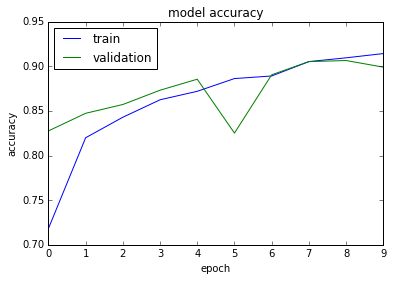

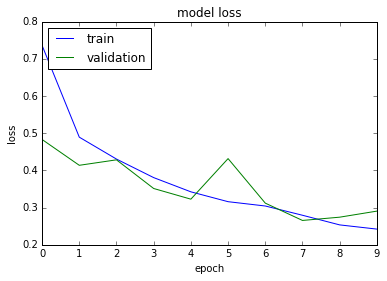

In [194]:
v = 1
result = fit_model(model, v, train_data, train_labels, val_data, val_labels)

Done building model.
Done compiling model.
Accuracy on test data: 0.912561576355
Classification Report
             precision    recall  f1-score   support

   laughter       0.94      0.71      0.81       153
    garbage       0.90      0.98      0.94       561
     filler       0.94      0.84      0.89        98

avg / total       0.91      0.91      0.91       812



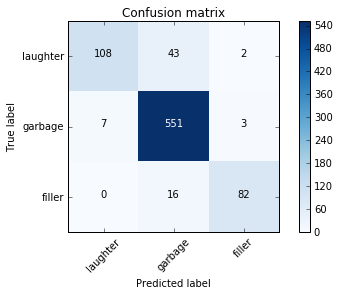

In [195]:
loaded_model = build_cnn(train_data.shape[1:])
evaluate_model(loaded_model, 'wav_classifier_weights_1.h5', test_data, test_labels)

[ 1.  0.  0.]


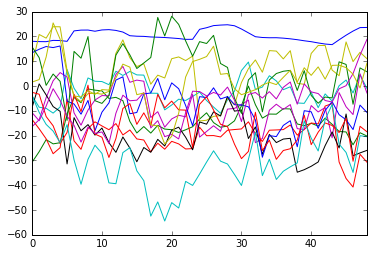

In [196]:
def display_mfcc(i):
    print y_data[i]
    pd.DataFrame(np.squeeze(x_data[i])).plot(legend=False)
#     plt.title(classes[y_data[i]])
    plt.show()
    
display_mfcc(12)